In [1]:
from pylab import *

In [2]:
from deficit_defs import *

Splikes version  0.1.4
Plasticnet version  0.1.12
macOS-15.3.1-arm64-arm-64bit
Base Image File: asdf/bbsk081604_all_scale2.asdf


In [3]:
def myfft2(im,x=None,y=None):
    from numpy.fft import fft2,fftshift,fftfreq
    
    ny,nx=im.shape
    
    if x is None:
        dx=1
    elif len(x.shape)==2:
        dx=x[0,1]-x[0,0]
    elif len(x.shape)==1:
        dx=x[1]-x[0]
    else:
        raise NotImplementedError
        
    if y is None:
        dy=1
    elif len(y.shape)==2:
        dy=y[1,0]-y[0,0]
    elif len(y.shape)==1:
        dy=y[1]-y[0]
    else:
        raise NotImplementedError
        
    
    
    imf=fftshift(fft2(im))
    kx = fftshift(fftfreq(nx,dx))
    ky = fftshift(fftfreq(ny,dy))
    
    return kx,ky,imf
    

In [5]:
im=pi5.filtered_images(
                    base_image_file,
                    {'type':'dog','sd1':1,'sd2':3},
                    {'type':'norm'},
                    )


Using cache_images/cache_images_f6d484251bbeda8699ed0b15303a996c.asdf from cache.

Sim Time Elapsed...2.64 s


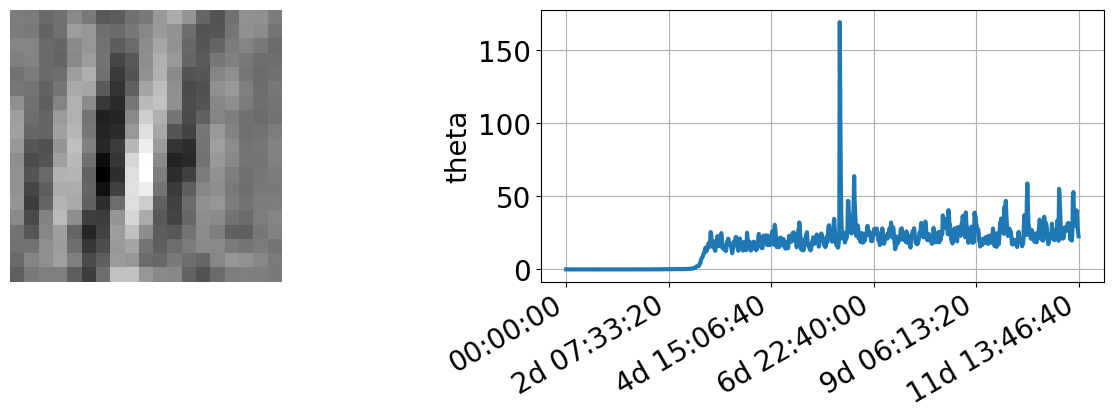

In [40]:
pre=pn.neurons.natural_images(im,rf_size=19,verbose=False)
post=pn.neurons.linear_neuron(1)
post+=pn.neurons.process.min_max(0,500)

c=pn.connections.BCM(pre,post,[-.01,.01])
c.eta=2e-6
c.tau=1000

sim=pn.simulation(1000*1000)
sim.monitor(c,['weights','theta'],1000)
sim+=pn.grating_response(print_time=False)

pn.run_sim(sim,[pre,post],[c],display_hash=False)

pn.utils.plot_rfs_and_theta(sim,[pre,post],[c]);

sfname='sims/2025-02-24/2025-02-24 Spatial Frequency RF.asdf'
pn.save(sfname,sim) 

In [41]:
c.weights.shape

(1, 361)

In [129]:
ww=sim.monitors['weights']
W=ww.array()[-1,0,:].reshape(19,19)

In [132]:
all(W.ravel()==c.weights)

True

(0.0, 19.0, 0.0, 19.0)

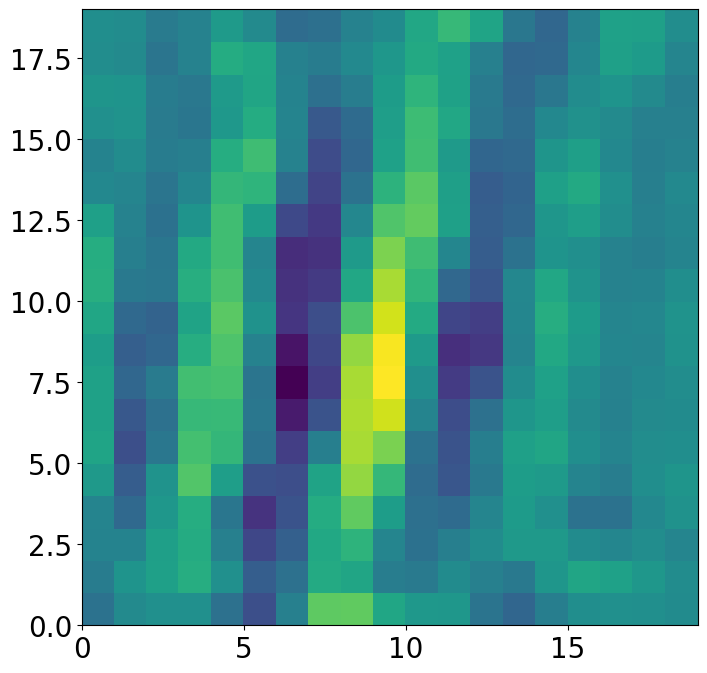

In [211]:
W=c.weights.reshape(19,19)
grid(False)
pcolor(W)
axis('square')

In [204]:
c.weights.ravel()[:19]

array([-0.17383556,  0.00435356,  0.04568772,  0.04575383, -0.18685346,
       -0.41474152, -0.07305405,  0.48817031,  0.49733862,  0.206089  ,
        0.10279439,  0.09740876, -0.15400947, -0.25834308, -0.08755637,
        0.03033206,  0.04117248,  0.03761106,  0.007587  ])

In [205]:
W=c.weights.reshape(19,19)
W[:2,:]


array([[-0.17383556,  0.00435356,  0.04568772,  0.04575383, -0.18685346,
        -0.41474152, -0.07305405,  0.48817031,  0.49733862,  0.206089  ,
         0.10279439,  0.09740876, -0.15400947, -0.25834308, -0.08755637,
         0.03033206,  0.04117248,  0.03761106,  0.007587  ],
       [-0.10066777,  0.07453969,  0.16120353,  0.26101993,  0.04568719,
        -0.31456203, -0.18261874,  0.23536989,  0.19784453, -0.09192899,
        -0.11698026,  0.0050556 , -0.07240041, -0.12480495,  0.09219183,
         0.19852179,  0.16876832,  0.09671802,  0.01205569]])

In [135]:
Wfft = np.fft.fftshift(abs(np.fft.fft2(W)));

In [136]:
Wfft.shape

(19, 19)

In [137]:
maxy,maxx=W.shape
center=(maxx/2)+1

In [138]:
argmax(W)

142

In [139]:
row,col=np.unravel_index(W.argmax(),W.shape)   # where is the maximum weight

In [140]:
deltay = center-row;
deltax = col-center;
rangle = np.arctan2(deltay,deltax)+pi/2;
dangle = (360/(2*pi))*rangle;

In [141]:
dangle %360

203.19859051364818

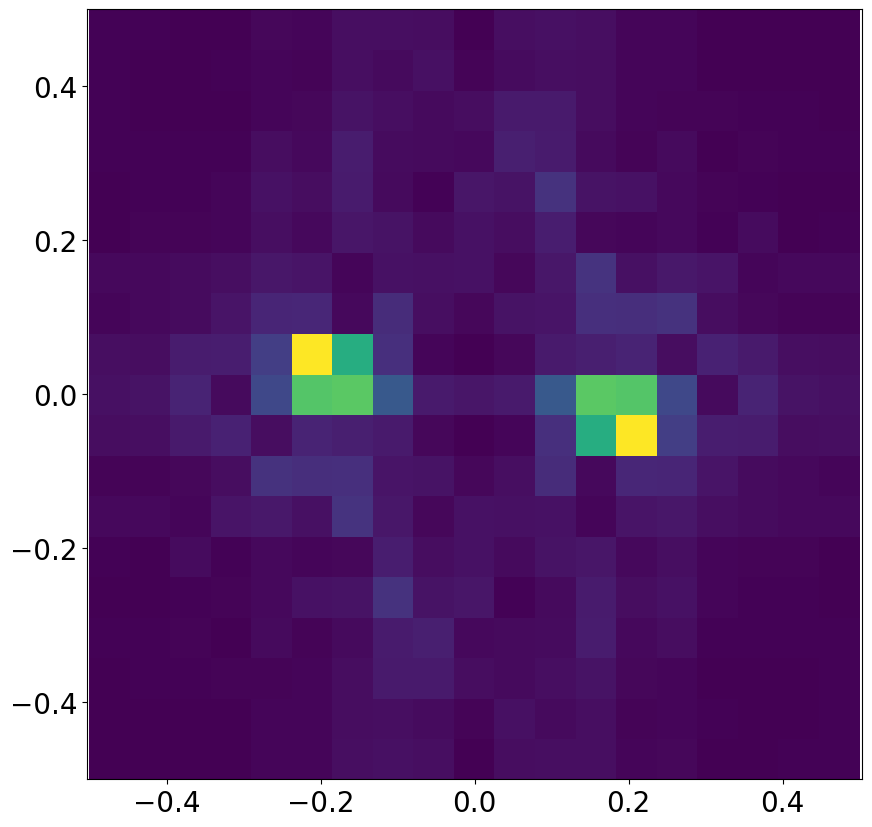

In [142]:
kx,ky,imf=myfft2(W)
imf=abs(imf)
figure(figsize=(10,10))
grid(False)
axis('equal')
pcolor(kx,ky,imf)

In [143]:
row,col=np.unravel_index(imf.argmax(),imf.shape)
rangle = np.degrees(np.arctan2(ky[row],kx[col])-pi/2)%360
rangle


255.96375653207352

In [144]:
ky

array([-0.47368421, -0.42105263, -0.36842105, -0.31578947, -0.26315789,
       -0.21052632, -0.15789474, -0.10526316, -0.05263158,  0.        ,
        0.05263158,  0.10526316,  0.15789474,  0.21052632,  0.26315789,
        0.31578947,  0.36842105,  0.42105263,  0.47368421])

In [145]:
all_responses,k_mat,theta_mat=get_responses(sfname)

In [146]:
k_mat

array([0.24166097, 0.35613196, 0.47060295, 0.58507394, 0.69954492,
       0.81401591, 0.9284869 , 1.04295788, 1.15742887, 1.27189986,
       1.38637085, 1.50084183, 1.61531282, 1.72978381, 1.8442548 ,
       1.95872578, 2.07319677, 2.18766776, 2.30213875, 2.41660973])

In [147]:
AR=all_responses[0]

(20, 24, 2, 4, 385)    # k, theta, channel, neuron, time

In [148]:
AR[1].shape

(20, 24, 1, 1, 1001)

In [222]:
resp=AR[1][:,:,0,0,-1]  # first channel, first neuron, last time point
resp.shape

(20, 24)

In [223]:
row,col=np.unravel_index(resp.argmax(),resp.shape)
row,col

(9, 10)

In [224]:
resp[row,:]

array([ 1.66620125,  1.15723854,  1.5767204 ,  2.37845483,  2.92065385,
        1.43689738,  2.36192305,  2.48755255,  4.08613359, 27.43195867,
       47.26302546, 41.75611176, 20.74067794,  5.20342565,  3.32424736,
        4.06160181,  4.59065275,  2.99523016,  3.56080794,  2.50301334,
        0.50090873,  1.52486926,  2.15623371,  1.66620128])

In [225]:
k=k_mat[row]
theta=theta_mat[col]
theta

78.26086956521739

In [264]:
def get_responses2(t,w,number_of_channels,rf_diameter,theta,k_mat):
    import numpy
    # weights.shape must be = (501, 3, 338)  t, neurons, inputs
    
    numang=len(theta)
    num_k=len(k_mat)
    L=len(t)
    num_neurons=w.shape[1]
    
    responses=numpy.zeros((num_k,numang,number_of_channels,num_neurons,L))

    rf_area=rf_diameter*rf_diameter
    rf_radius=rf_diameter//2

    ii=zeros((rf_diameter,rf_diameter))
    jj=zeros((rf_diameter,rf_diameter))
    ww=zeros((rf_diameter,rf_diameter))
    for ti in range(L):
        for ni in range(num_neurons):
            for ch in range(number_of_channels):
                for ki,k in enumerate(k_mat):
                    for ai,th in enumerate(theta):
                        a=3.14159265-th/180.0*3.14159265
                        kx=k*cos(a)
                        ky=k*sin(a)


                        if ki==9:
                            print(th,k,kx,ky)
                        cs=0.0
                        cc=0.0
                        wi=0
                        for i in range(rf_diameter):
                            for j in range(rf_diameter):

                                ds=sin(kx*(i-rf_radius)+ ky*(j-rf_radius))
                                dc=cos(kx*(i-rf_radius)+ ky*(j-rf_radius))

                                w1=w[ti,ni,wi+rf_area*ch]
                                    
                                cs+=w1*ds # response to sin/cos grating input
                                cc+=w1*dc


                                wi+=1

                                ii[i,j]=i
                                jj[i,j]=j
                                ww[i,j]=w1

                        phi=atan2(cc,cs)  # phase to give max response
                        c=cs*cos(phi)+cc*sin(phi)     # max response

                        responses[ki,ai,ch,ni,ti]=c
                        if ki==9:
                            print(">>",cc,cs,phi,c)
                            return responses,(ii,jj,ww)
                        
    return responses,(ii,jj,ww)


In [265]:
ww=sim.monitors['weights']
t,W=ww.arrays()
t=array([t[_] for _ in [-1,0]])
W=array([W[_,::] for _ in [-1,0]])
W.shape

(2, 1, 361)

In [266]:
AR2,rest=get_responses2(t,W,1,19,theta_mat,k_mat)
AR2.shape

0.0 1.2718998597529525 -1.2718998597529525 4.5658572511976725e-09
>> 0.17308612491811914 -1.657186713743144 3.037524224110006 1.6662012516037707


(20, 24, 1, 1, 2)

True

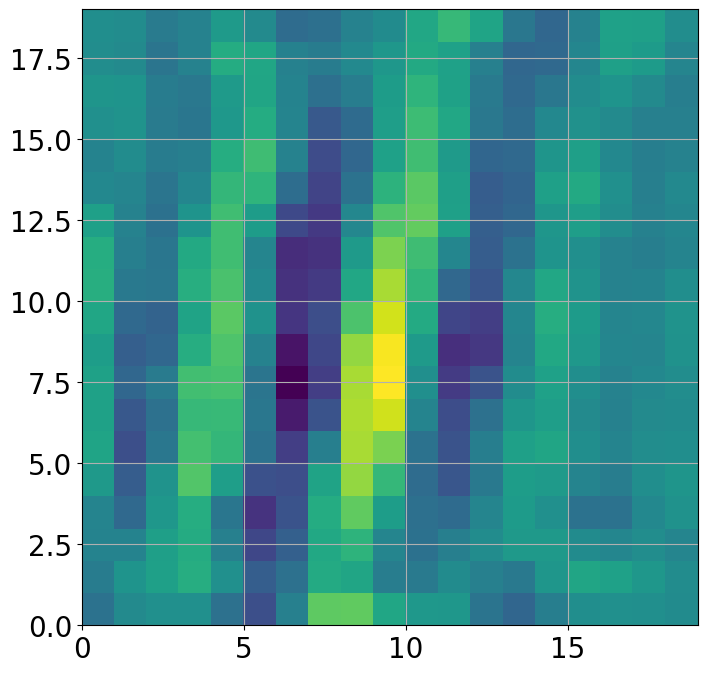

In [274]:
ii,jj,ww=rest
pcolor(ww)
axis('square')
not any(ww-c.weights.reshape((19,19)))

In [279]:
theta=0
W=c.weights.reshape((19,19))
a=radians(180-theta)
kx=k*cos(a)
ky=k*sin(a)

rf_radius=19//2
j,i=meshgrid(arange(19),arange(19))


dc=cos(kx*(i-rf_radius)+ ky*(j-rf_radius))
ds=sin(kx*(i-rf_radius)+ ky*(j-rf_radius))


ys=(W*ds).sum() # response to sin/cos grating input
yc=(W*dc).sum()

phi=atan2(yc,ys)  # phase to give max response
y=ys*cos(phi)+yc*sin(phi)     # max response


yc,ys,phi,y

(0.17308615986076648,
 -1.6571867347168927,
 3.0375242045596473,
 1.6662012760939127)

In [254]:
resp2=AR[1][:,:,0,0,-1]  # first channel, first neuron, last time point
resp2.shape

(20, 24)

In [194]:
row,col=np.unravel_index(resp2.argmax(),resp2.shape)
row,col

(9, 10)

In [195]:
resp2[row,:],resp[row,:]  # ok, so this is repeatable

(array([ 1.66620125,  1.15723854,  1.5767204 ,  2.37845483,  2.92065385,
         1.43689738,  2.36192305,  2.48755255,  4.08613359, 27.43195867,
        47.26302546, 41.75611176, 20.74067794,  5.20342565,  3.32424736,
         4.06160181,  4.59065275,  2.99523016,  3.56080794,  2.50301334,
         0.50090873,  1.52486926,  2.15623371,  1.66620128]),
 array([ 1.66620125,  1.15723854,  1.5767204 ,  2.37845483,  2.92065385,
         1.43689738,  2.36192305,  2.48755255,  4.08613359, 27.43195867,
        47.26302546, 41.75611176, 20.74067794,  5.20342565,  3.32424736,
         4.06160181,  4.59065275,  2.99523016,  3.56080794,  2.50301334,
         0.50090873,  1.52486926,  2.15623371,  1.66620128]))

In [196]:
ii,jj,ww=rest

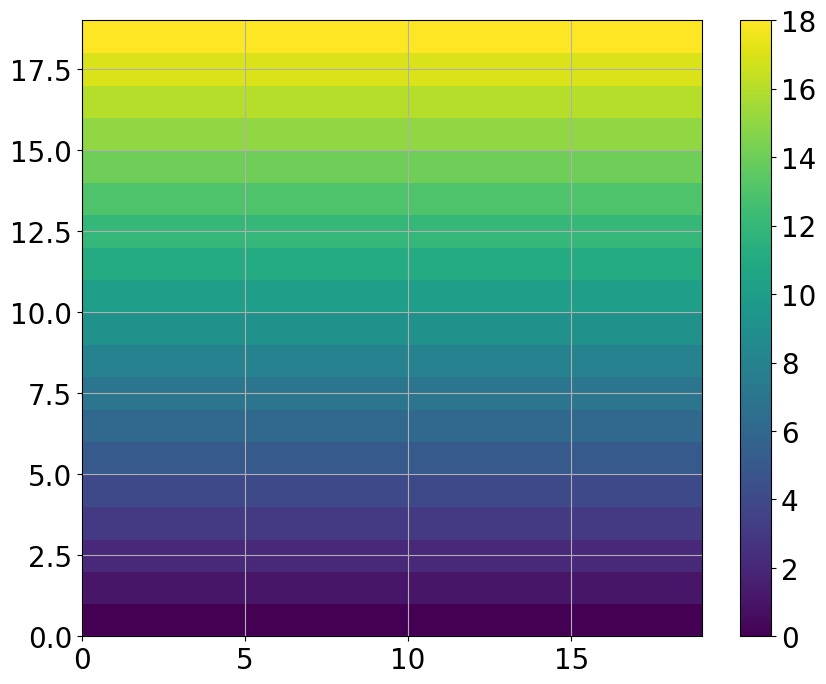

In [213]:
ii,jj,ww=rest
pcolor(ii)
colorbar()

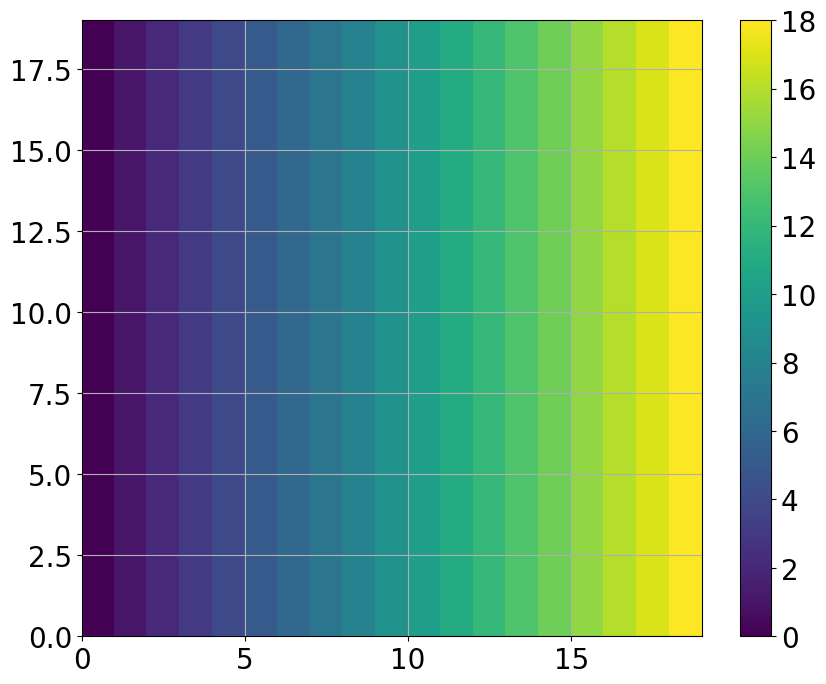

In [220]:
jj,ii=meshgrid(arange(19),arange(19))
pcolor(jj)
colorbar()

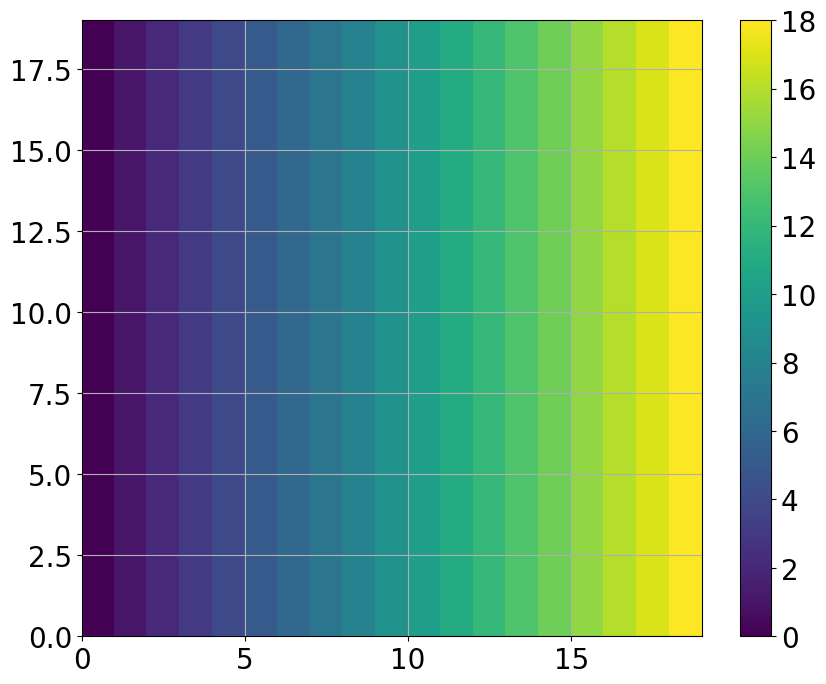

In [212]:
pcolor(jj)
colorbar()

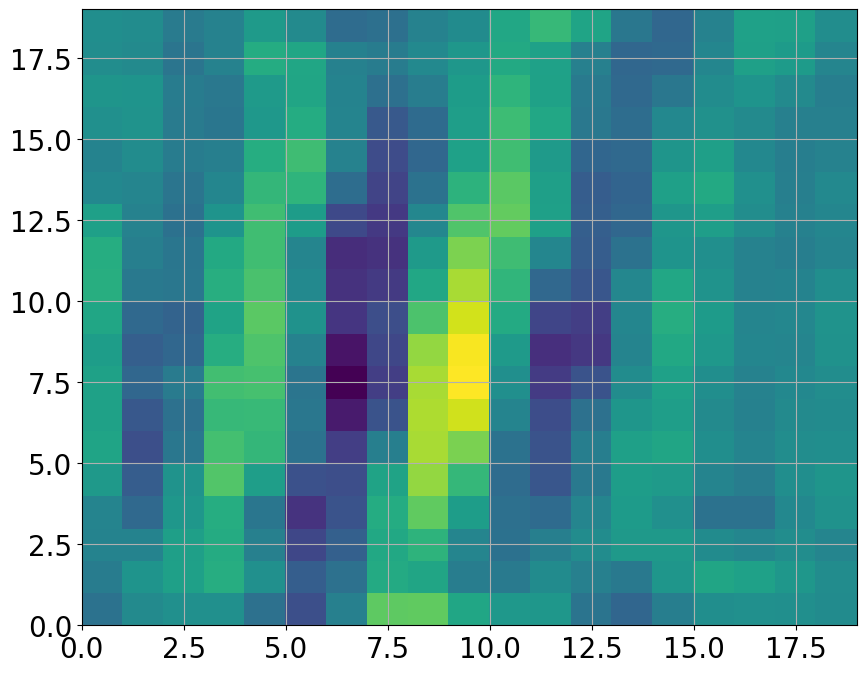

In [214]:
WW=ww.reshape((19,19))
pcolor(WW)

In [207]:
WW[:2,:],W[:2,:]

(array([[-0.17383556,  0.00435356,  0.04568772,  0.04575383, -0.18685346,
         -0.41474152, -0.07305405,  0.48817031,  0.49733862,  0.206089  ,
          0.10279439,  0.09740876, -0.15400947, -0.25834308, -0.08755637,
          0.03033206,  0.04117248,  0.03761106,  0.007587  ],
        [-0.10066777,  0.07453969,  0.16120353,  0.26101993,  0.04568719,
         -0.31456203, -0.18261874,  0.23536989,  0.19784453, -0.09192899,
         -0.11698026,  0.0050556 , -0.07240041, -0.12480495,  0.09219183,
          0.19852179,  0.16876832,  0.09671802,  0.01205569]]),
 array([[-0.17383556,  0.00435356,  0.04568772,  0.04575383, -0.18685346,
         -0.41474152, -0.07305405,  0.48817031,  0.49733862,  0.206089  ,
          0.10279439,  0.09740876, -0.15400947, -0.25834308, -0.08755637,
          0.03033206,  0.04117248,  0.03761106,  0.007587  ],
        [-0.10066777,  0.07453969,  0.16120353,  0.26101993,  0.04568719,
         -0.31456203, -0.18261874,  0.23536989,  0.19784453, -0.09192899

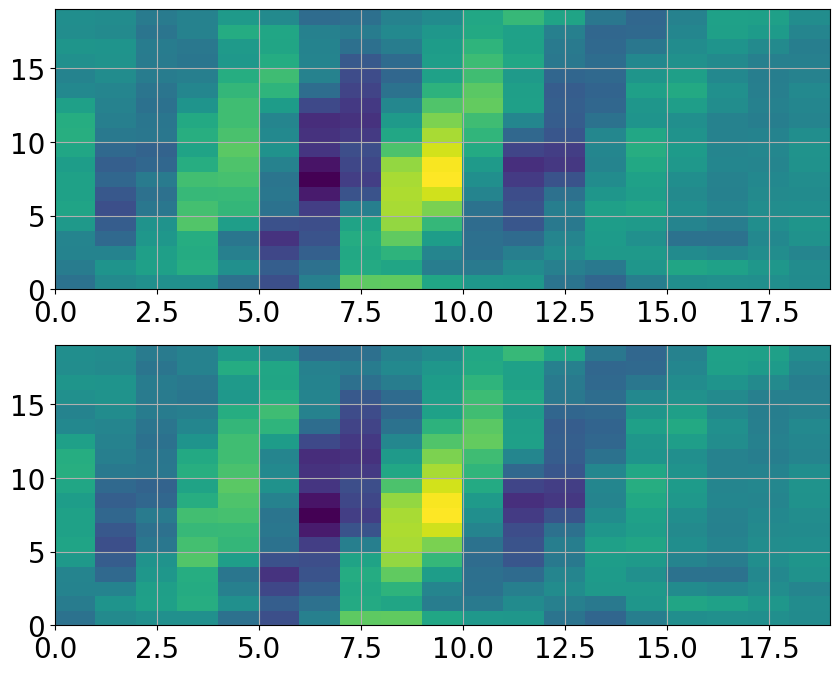

In [215]:
subplot(2,1,1)
pcolor(WW)
subplot(2,1,2)
pcolor(W)

-0.2587756744675399 1.245296913809494


(47.230819088667744, 1.7445035488834995)

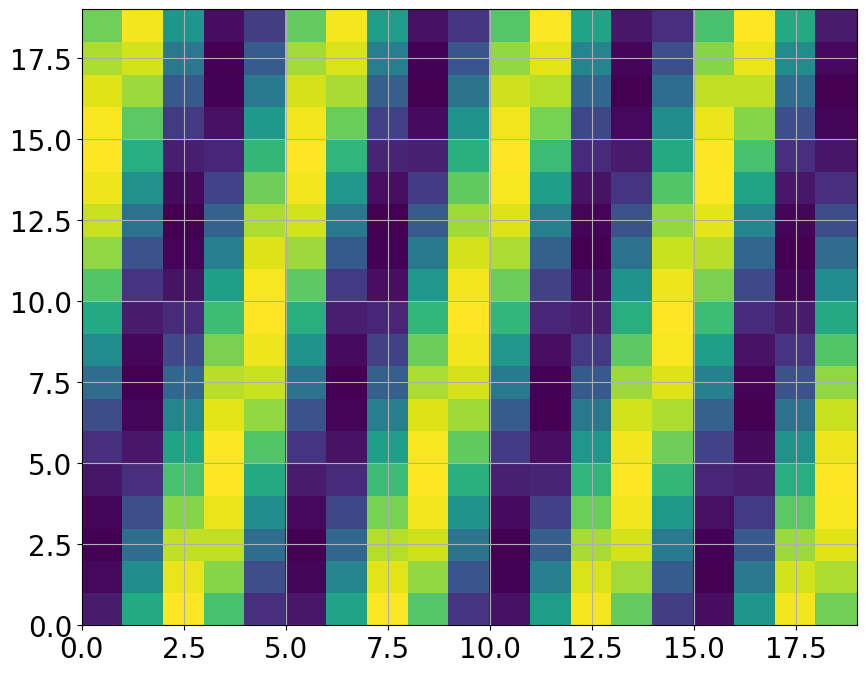

In [227]:
a=radians(180-theta)
kx=k*cos(a)
ky=k*sin(a)
rf_radius=19//2
j,i=meshgrid(arange(19),arange(19))

dc=cos(kx*(i-rf_radius)+ ky*(j-rf_radius))
ds=sin(kx*(i-rf_radius)+ ky*(j-rf_radius))
pcolor(dc)
print(kx,ky)
(dc*W).sum(),(ds*W).sum()

    0.0 1.2718998597529525 -1.2718998597529525 4.5658572511976725e-09
    7.826086956521739 1.2718998597529525 -1.2600533152281437 0.1731903462152097
    15.652173913043478 1.2718998597529525 -1.2247343616066235 0.34315447941065363
    23.47826086956522 1.2718998597529525 -1.1666009241668325 0.506726293942472
    31.304347826086957 1.2718998597529525 -1.0867359188531158 0.6608587564026478
    39.130434782608695 1.2718998597529525 -0.9866270796006797 0.8026806706519188
    46.95652173913044 1.2718998597529525 -0.868139244667344 0.9295501627712157
    54.78260869565217 1.2718998597529525 -0.7334796182252878 1.0391038941740456
    62.608695652173914 1.2718998597529525 -0.5851566543236039 1.1293010861326516
    70.43478260869566 1.2718998597529525 -0.42593332913565235 1.1984615356243187
    78.26086956521739 1.2718998597529525 -0.25877567194081574 1.2452969143345531
    86.08695652173913 1.2718998597529525 -0.0867975136110951 1.2689347677759137
    93.91304347826087 1.2718998597529525 0.08679751816630829 1.2689347674643285
    101.73913043478261 1.2718998597529525 0.25877567641117366 1.2452969134056022
    109.56521739130434 1.2718998597529525 0.4259333334378809 1.1984615340953064
    117.3913043478261 1.2718998597529525 0.585156658377561 1.1293010840320603
    125.21739130434783 1.2718998597529525 0.7334796219554554 1.0391038915410058
    133.04347826086956 1.2718998597529525 0.8681392480042367 0.9295501596547755
    140.8695652173913 1.2718998597529525 0.9866270824821372 0.8026806671101319
    148.69565217391303 1.2718998597529525 1.0867359212254617 0.6608587525014913
    156.52173913043478 1.2718998597529525 1.166600925985875 0.5067262897546161
    164.34782608695653 1.2718998597529525 1.224734362838477 0.34315447501411017
    172.17391304347825 1.2718998597529525 1.2600533158498612 0.17319034169187908
    180.0 1.2718998597529525 1.2718998597529525 0.0

0.0 1.2718998597529525 -1.2718998597529525 1.5576280920824208e-16
-1.6571867347168927 0.17308615986076648
7.826086956521739 1.2718998597529525 -1.2600533158228302 0.17319034188854562
-0.9725104969285356 -0.6272355012494457
15.652173913043478 1.2718998597529525 -1.2247343627313594 0.3431544753964186
-1.552630858176295 -0.27456248440482844
23.47826086956522 1.2718998597529525 -1.1666009257486087 0.5067262903008578
-2.255090685636902 -0.75605112218789
31.304347826086957 1.2718998597529525 -1.0867359208128797 0.6608587531799535
-2.2313191107717967 -1.8845248721966352
39.130434782608695 1.2718998597529525 -0.9866270818557334 0.8026806678800854
-1.3713713238937721 0.42896945850229384
46.95652173913044 1.2718998597529525 -0.8681392471337429 0.9295501604677601
0.4825398567710968 2.312106381108424
54.78260869565217 1.2718998597529525 -0.7334796208201869 1.0391038923423659
1.548848588776134 -1.9465316441832625
62.608695652173914 1.2718998597529525 -0.5851566569674892 1.1293010847627007
3.0159390

(array([ 1.66620128,  1.15723854,  1.57672037,  2.37845481,  2.92065386,
         1.43689739,  2.36192308,  2.48755249,  4.08613338, 27.43195823,
        47.26302534, 41.75611199, 20.7406782 ,  5.20342574,  3.32424737,
         4.06160178,  4.59065277,  2.99523016,  3.56080794,  2.50301335,
         0.50090874,  1.52486926,  2.15623371,  1.66620128]),
 array([ 1.66620125,  1.15723854,  1.5767204 ,  2.37845483,  2.92065385,
         1.43689738,  2.36192305,  2.48755255,  4.08613359, 27.43195867,
        47.26302546, 41.75611176, 20.74067794,  5.20342565,  3.32424736,
         4.06160181,  4.59065275,  2.99523016,  3.56080794,  2.50301334,
         0.50090873,  1.52486926,  2.15623371,  1.66620128]))

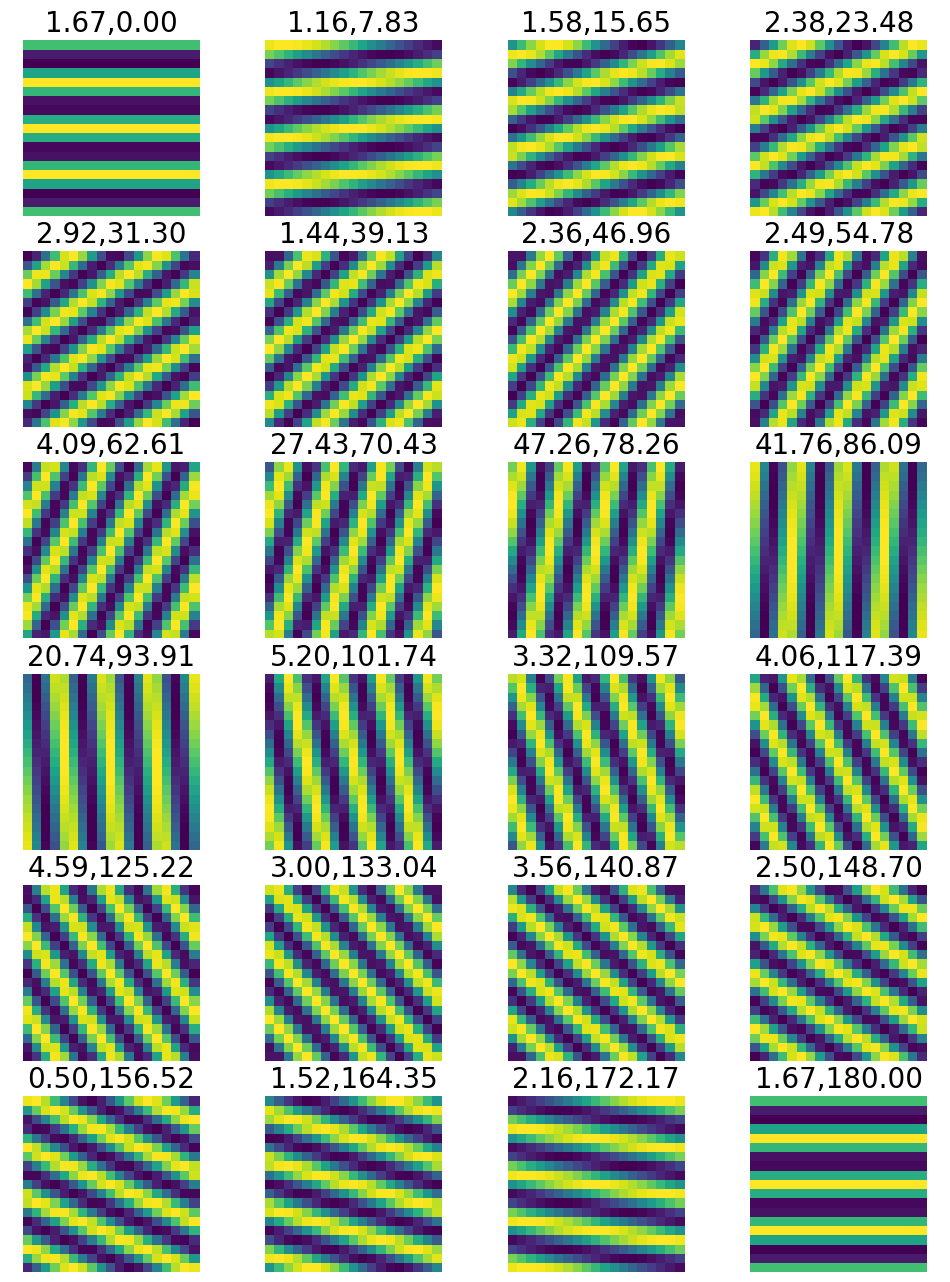

In [280]:
figure(figsize=(12,16))
yy=zeros(len(theta_mat))
W=c.weights.reshape(19,19)

for theta_i,theta in enumerate(theta_mat):
    a=radians(180-theta)
    kx=k*cos(a)
    ky=k*sin(a)

    print(theta,k,kx,ky)
    rf_radius=19//2
    j,i=meshgrid(arange(19),arange(19))
    
    
    dc=cos(kx*(i-rf_radius)+ ky*(j-rf_radius))
    ds=sin(kx*(i-rf_radius)+ ky*(j-rf_radius))


    ys=(W*ds).sum() # response to sin/cos grating input
    yc=(W*dc).sum()


    print(ys,yc)
    phi=atan2(yc,ys)  # phase to give max response
    y=ys*cos(phi)+yc*sin(phi)     # max response
    yy[theta_i]=y
    
    subplot(6,4,theta_i+1)
    
    pcolor(ds*cos(phi)+dc*sin(phi))
    pcolor(dc)
    axis('equal')
    axis('off')
    title(f"{y:.2f},{theta:.2f}")


yy,array([ 1.66620125,  1.15723854,  1.5767204 ,  2.37845483,  2.92065385,
         1.43689738,  2.36192305,  2.48755255,  4.08613359, 27.43195867,
        47.26302546, 41.75611176, 20.74067794,  5.20342565,  3.32424736,
         4.06160181,  4.59065275,  2.99523016,  3.56080794,  2.50301334,
         0.50090873,  1.52486926,  2.15623371,  1.66620128])

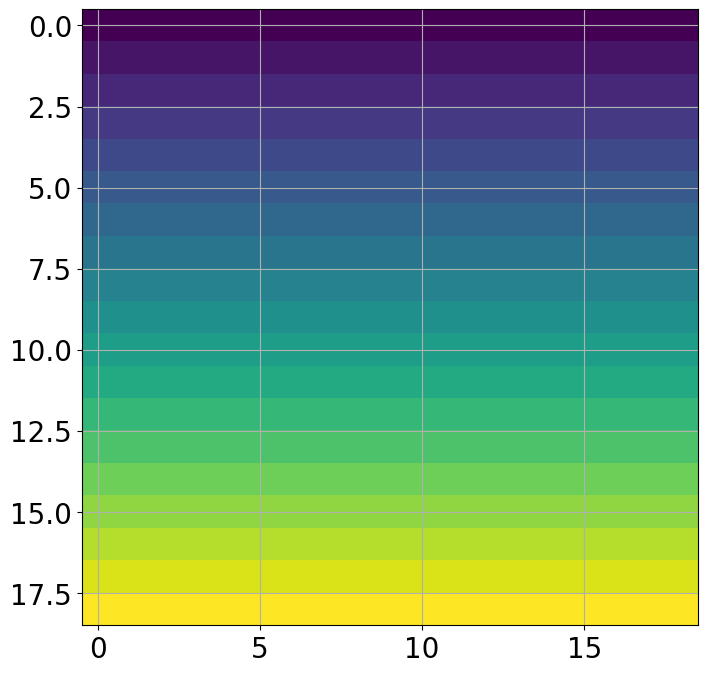

In [119]:
imshow(j)

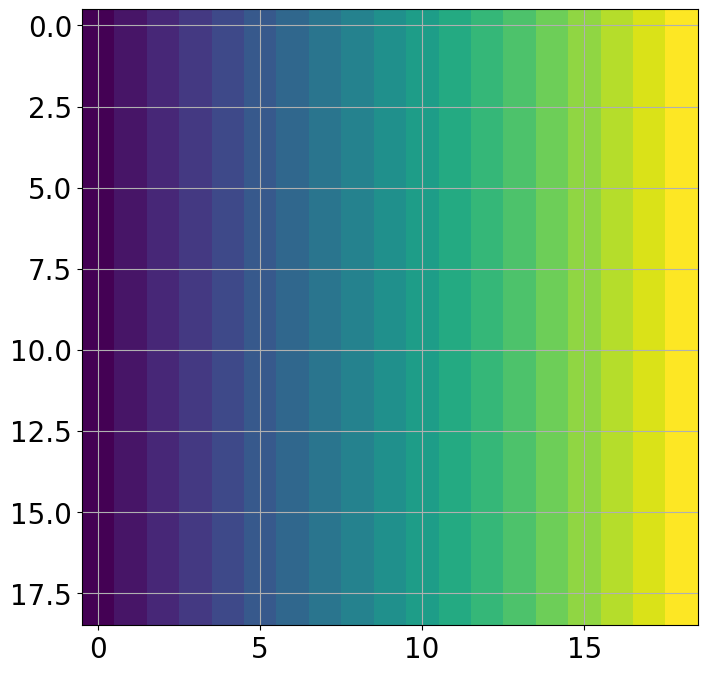

In [92]:
imshow(i)

(0.0, 59.0, 0.0, 59.0)

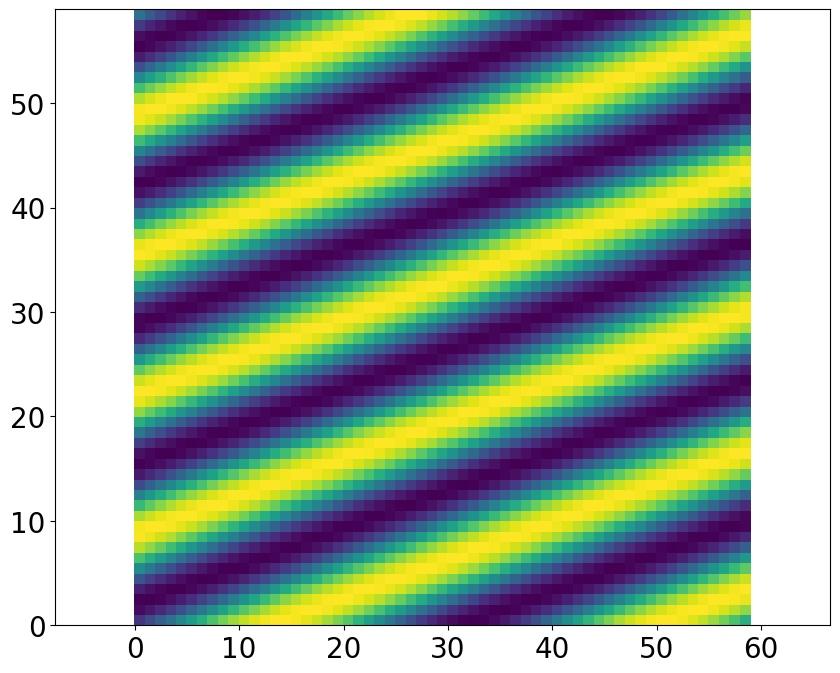

In [21]:
rf_diameter=59
θ=20 # degrees

rot=radians(-θ)

y,x= mgrid[-rf_diameter//2:rf_diameter//2,
                -rf_diameter//2:rf_diameter//2]
x=x+1
y=y+1


i,j= mgrid[-rf_diameter//2:rf_diameter//2,
                -rf_diameter//2:rf_diameter//2]
i=i+1
j=j+1

k=0.5

kx=k*cos(rot)
ky=k*sin(rot)


im=sin(kx*i+ky*j)
grid(False)
pcolor(im)
axis('equal')

25 31


26.565051177078004

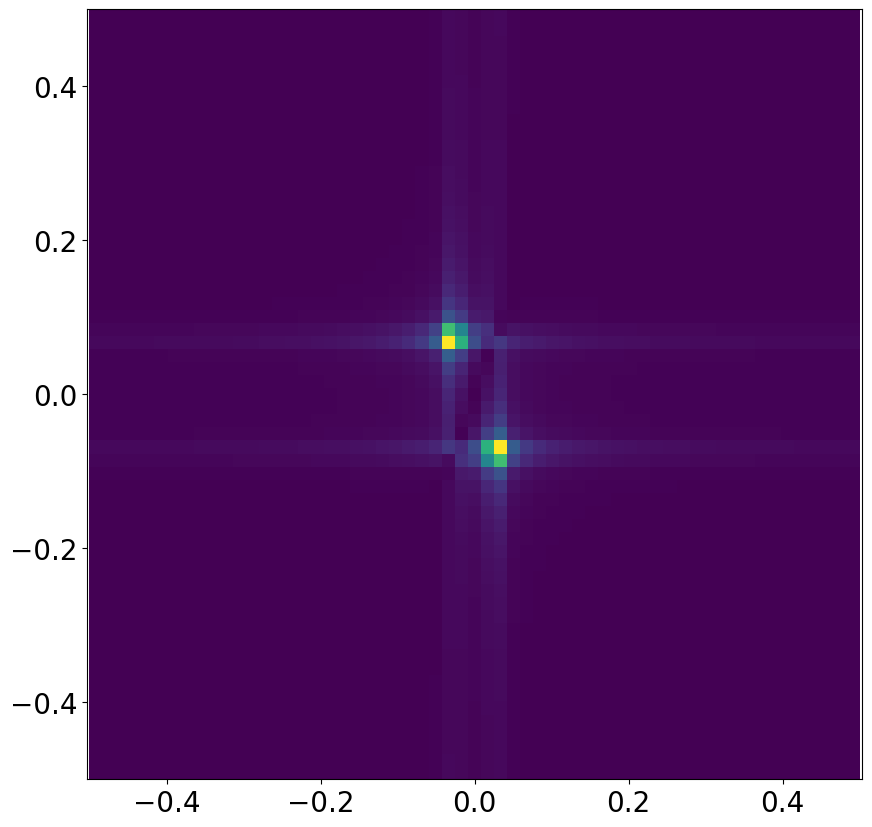

In [22]:
kx,ky,imf=myfft2(im,x,y)
imf=abs(imf)
figure(figsize=(10,10))
grid(False)
axis('equal')
pcolor(kx,ky,imf)
row,col=np.unravel_index(imf.argmax(),imf.shape)
print(row,col)
rangle = np.degrees(np.arctan2(ky[row],kx[col])-pi/2)%180
rangle


(-29.1, 29.899999999999793, -29.05, 29.950000000000838)

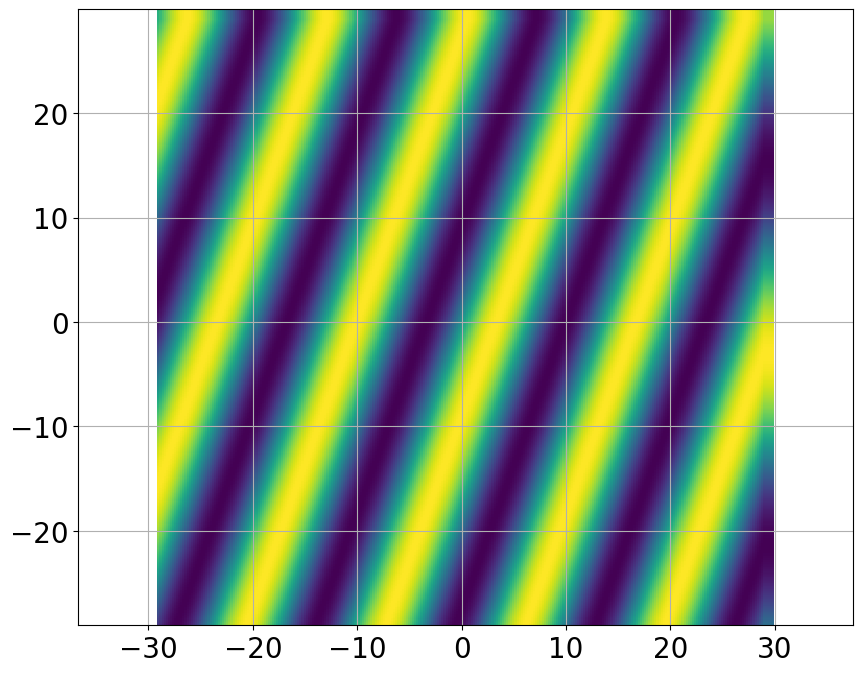

In [23]:
from scipy.interpolate import interp2d,RectBivariateSpline
x=arange(-rf_diameter//2,rf_diameter//2)
y=arange(-rf_diameter//2,rf_diameter//2)

x=x+1
y=y+1

f=RectBivariateSpline(x, y, im)

xx=arange(-rf_diameter//2,rf_diameter//2,.2)
yy=arange(-rf_diameter//2,rf_diameter//2,.1)
xx=xx+1
yy=yy+1

im2 = f(xx, yy).T
pcolor(xx,yy,im2)
axis('equal')

In [24]:
im2.shape

(590, 295)

In [25]:
x.shape

(59,)

293 151


63.43494882292242

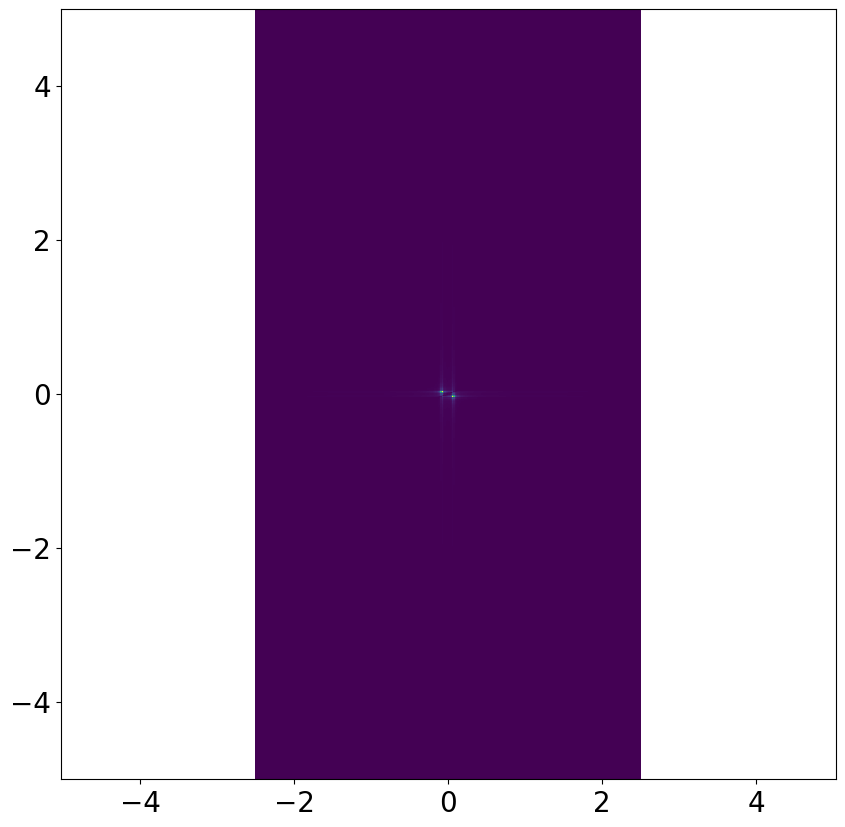

In [26]:
kx,ky,imf=myfft2(im2,xx,yy)
imf=abs(imf)
figure(figsize=(10,10))
grid(False)
axis('equal')
pcolor(kx,ky,imf)
row,col=np.unravel_index(imf.argmax(),imf.shape)
print(row,col)
rangle = np.degrees(np.arctan2(ky[row],kx[col])-pi/2)%180
rangle
